## Predição de rotatividade de clientes com Ciência de Dados

Este projeto tem o objetivo de prever a rotatividade de consumidores a partir de informações pessoais, de pagamentos e serviços contratados. A *rotatividade* em questão é a análise dos consumidores com intenção de parar de adquirir os serviços (ou seja, "deixar" a empresa).

**Integrantes:**
- André Luís Mendes Fakhoury
- Gustavo Vinícius Vieira Silva Soares
- Thiago Preischadt Pinheiro

**Prof.** Francisco Aparecido Rodrigues

<center>
USP - ICMC - 2021
</center>

#### Descrição dos atributos

1. customerID: Código identificador do consumidor
2. gender: Gênero do passageiro (Male/Female)
3. SeniorCitizen: Indica se o consumidor é um cidadão sênior (0/1)
4. Partner: Indica se o consumidor possui parceiro (Yes/No)
5. Dependents: Indica se o consumidor possui dependentes (Yes/No)
6. tenure: Número de meses que o consumidor permaneceu na empresa
7. PhoneService: Indica se o consumidor possui serviço de telefone ou não (Yes/No)
8. MultipleLines: Indica se o consumidor possui multiplas linhas ou não (Yes/No/No phone service)
9. InternetService: Provedor de internet do cliente (DSL/Fiber optic/No)
10. OnlineSecurity: Indica se o consumidor possui segurança online ou não (Yes/No/No internet service)
11. OnlineBackup: Indica se o consumidor possui backup online ou não (Yes/No/No internet service)
12. DeviceProtection: Indica se o consumidor possui proteção de dispositivo ou não (Yes/No/No internet service)
13. TechSupport: Indica se o consumidor possui suporte técnico ou não (Yes/No/No internet service)
14. StreamingTV: Indica se o consumidor possui serviço de streaming de TV ou não (Yes/No/No internet service)
15. StreamingMovies: Indica se o consumidor possui serviço de streaming de filmes ou não (Yes/No/No internet service)
16. Contract: O termo de contrato do consumidor (Month-to-month/One year/Two year)
17. PaperlessBilling: Indica se o consumidor tem cobrança sem papel ou não (Yes/No)
18. PaymentMethod: Método de cobrança do cliente (Electronic check/Mailed check/Bank transfer (automatic)/Credit card (automatic))
19. MonthlyCharges: Total cobrado do consumidor mensalmente
20. TotalCharges: Total cobrado do consumidor
21. Churn: Indica se o consumidor cancelou o plano ou não (Yes/No)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split

## Preparação dos Dados

Nessa etapa, os dados serão preparados com o objetivo de prepará-los para etapas posteriores do projeto. Será feita a limpeza de dados utilizando métodos de transformação de dados e pré-processamento.

In [2]:
df = pd.read_csv('churn.csv')
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Primeiramente, pode-se remover a coluna de "customerID", pois não terá importância para as próximas etapas. Antes disso, é possível verificar se existem campos duplicados, pois trata-se de um campo identificador único do cliente.

In [3]:
df['customerID'].duplicated().any()

False

O campo customerId não tem elementos repetidos, portanto pode-se removê-lo.

In [4]:
df.drop(columns=['customerID'], inplace=True)

Outro tratamento a se realizar é a transformação do campo "TotalCharges" para *float*. Porém, para isso, é necessário tratar alguns de seus valores, que possuem a string vazia ' '. Esses valores são então substituídos para uma aproximação, calculada pelo respectivo campo "MonthlyCharges" multiplicado pelo "tenure".

In [5]:
mask = df['TotalCharges'] != ' '

error = (df.loc[mask, 'TotalCharges'].astype(float) - df.loc[mask, 'MonthlyCharges'] * df.loc[mask, 'tenure']).abs().mean()
print(f'Error: {error}')
print(df.loc[mask, 'TotalCharges'].astype(float).describe())

Error: 45.08915671217292
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


Pode-se perceber que a aproximação é boa pois o erro é pequeno. Logo, pode-se realizá-la:

In [6]:
mask = df['TotalCharges'] == ' '
df.loc[mask, 'TotalCharges'] = df.loc[mask, 'MonthlyCharges'] * df.loc[mask, 'tenure']
df['TotalCharges'] = df['TotalCharges'].astype(float)

Agora, verifica-se se tem alguns campos vazios (sem valores). Para isso, utiliza-se a função 'isna()':

In [7]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Logo, não existem células nulas, então não é necessário nenhum tratamento sob isso.

## Análise Exploratória de Dados

Nessa etapa, os dados serão analisados a partir de medidas estatísticas, e visualizados de forma gráfica, com o objetivo de verificar como eles estão dispostos no *dataset* e como se relacionam com outros dados.

In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Podemos analisar agora a relação entre o target e algumas features.

Text(0.5, 1.0, 'Distribuição da variável target')

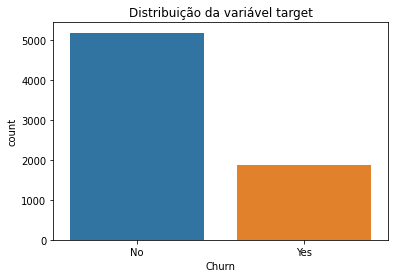

In [9]:
sns.countplot(x='Churn', data=df).set_title('Distribuição da variável target')

Text(0.5, 1.0, 'Distribuição da variável target pelo gênero')

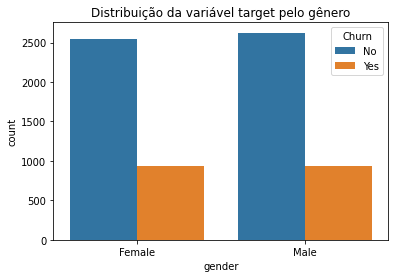

In [10]:
sns.countplot(x='gender', hue='Churn', data=df).set_title('Distribuição da variável target pelo gênero')

Text(0.5, 1.0, 'Distribuição da variável target pelo tipo de internet')

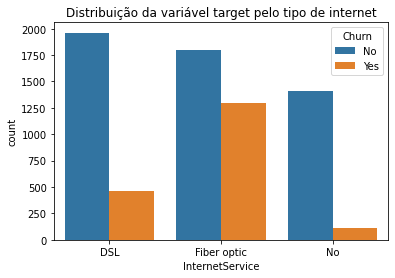

In [11]:
sns.countplot(x='InternetService', hue='Churn', data=df).set_title('Distribuição da variável target pelo tipo de internet')

Text(0.5, 1.0, 'Distribuição da variável target pelo uso de telefone')

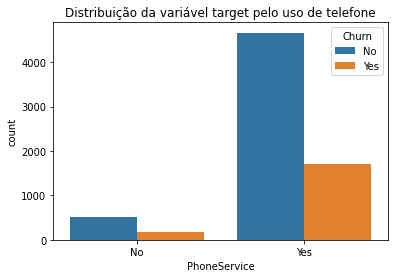

In [12]:
sns.countplot(x='PhoneService', hue='Churn', data=df).set_title('Distribuição da variável target pelo uso de telefone')

<AxesSubplot:>

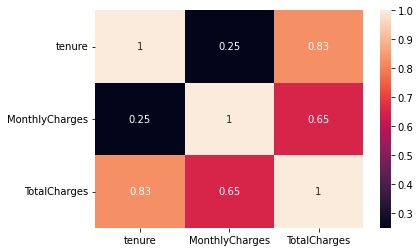

In [13]:
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True)

A variável 'TotalCharges' está fortemente correlacionada com 'MonthlyCharges' e 'tenure'.

<AxesSubplot:xlabel='tenure', ylabel='Count'>

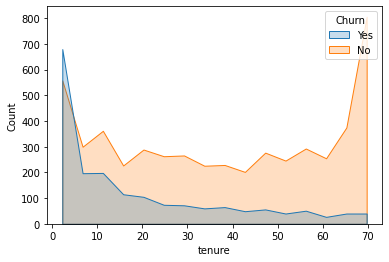

In [14]:
sns.histplot(df, x='tenure', hue='Churn', hue_order=['Yes', 'No'], element='poly')

Há uma relação entre 'tenure' e 'Churn'. Os consumidores que utilizam o serviço por mais tempo tendem a permanecer, enquanto os que abandonam tendem a ser os consumidores que utilizaram o serviço por um tempo menor.

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

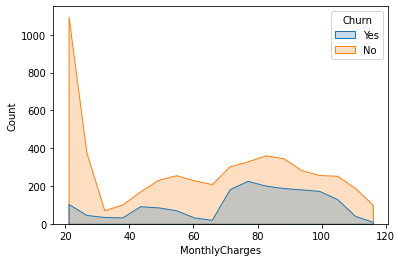

In [15]:
sns.histplot(df, x='MonthlyCharges', hue='Churn', hue_order=['Yes', 'No'], element='poly')

Há uma relação entre 'MonthlyCharges' e 'Churn'. Os consumidores que pagam um maior valor mensal tem uma maior tendência de cancelar o serviço, enquanto aqueles que pagam valores baixos tendem a permanecer.

<AxesSubplot:xlabel='tenure', ylabel='TotalCharges'>

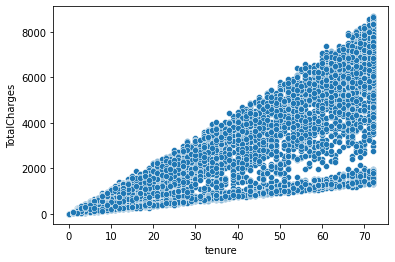

In [16]:
sns.scatterplot(data=df, x='tenure', y='TotalCharges')

É perceptível a relação entre o tempo de uso do serviço e o total gasto. Consumidores que ficam por mais tempo tem um gasto maior.

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

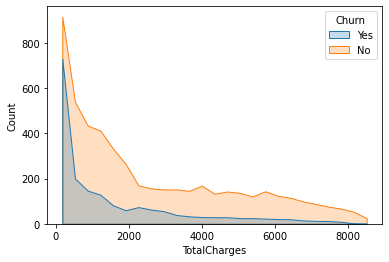

In [17]:
sns.histplot(df, x='TotalCharges', hue='Churn', hue_order=['Yes', 'No'], element='poly')

Também há uma relação entre 'TotalCharges' e 'Churn'. Os consumidores que tem um gasto total maior são aqueles que estão a mais tempo no serviço e em geral costumam não cancelar o plano.

## Treinamento e Utilização dos Modelos

Faremos as seguintes transformações:

- Colunas com `yes` e `no` se tornarão `1` e `0`, respectivamente.
- Colunas com `Female` e `Male` se tornarão `1` e `0`, respectivamente.
- Faremos `One Hot Encoding` das colunas categóricas: `InternetService`,`Contract` e `PaymentMethod`

In [18]:
for col in ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']:
    df[col] = df[col].map(lambda x: int(x == 'Yes'))
df['gender'] = df['gender'].map(lambda x: int(x == 'Female'))

In [19]:
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


Verificando se os tipos são todos numéricos após as transformações aplicadas

In [20]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

Agora vamos utilizar o `StandardScaler` para transformar os valores das colunas numéricas

In [21]:
x = df.drop('Churn', axis=1)
y = df['Churn']

columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
x.loc[:, columns] = StandardScaler().fit_transform(x.loc[:, columns])

Agora, pode-se obter uma ideia da separação entre as classes ao projetar os atributos em duas dimensões, utilizando PCA:

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

Utilizaremos o método `K-Fold Cross Validation` para validar os modelos escolhidos, utilizando `k=4`

In [23]:
def validate_model(model, x, y):
    kf = KFold(n_splits=4, random_state=42, shuffle=True)

    scores = []
    for train_index, validation_index in kf.split(x):
        x_train, x_validation = x.iloc[train_index], x.iloc[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_validation)
        scores.append(roc_auc_score(y_validation, y_pred))
    return scores

Agora, iremos testar vários modelos (alternando seus parâmetros quando conveniente), utilizando o ROC Score de cada um para verificar qual é mais apropriado. Os modelos a serem utilizados são: Regressão Logística, Naive Bayes, K-Nearest Neighbours, Árvore de Decisão e Floresta Aleatória.

#### Modelo 1: Regressão Logística

In [24]:
model = LogisticRegression(random_state=42)
scores = validate_model(model, x_train, y_train)
print(f'Scores: {scores}, Mean: {np.mean(scores)}')

Scores: [0.7161382106696113, 0.7122080587351138, 0.7254792029699219, 0.7064812679165705], Mean: 0.7150766850728043


#### Modelo 2: Naive Bayes

In [25]:
model = GaussianNB()
scores = validate_model(model, x_train, y_train)
print(f'Scores: {scores}, Mean: {np.mean(scores)}')

Scores: [0.7468815545779071, 0.735742571395537, 0.7763239639366618, 0.7481795116807802], Mean: 0.7517819003977215


#### Modelo 3: KNN

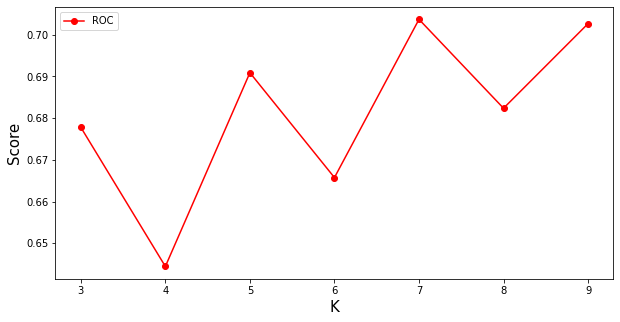

In [26]:
x_plot = range(3, 10)
y_plot = []

for n_neighbors in x_plot:
    model = KNeighborsClassifier(n_neighbors)
    scores = validate_model(model, x_train, y_train)
    y_plot.append(np.mean(scores))

plt.figure(figsize=(10,5))
plt.plot(x_plot, y_plot, '-ro', label='ROC')
plt.xlabel('K', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()
plt.show()

#### Modelo 4: Árvore de Decisão

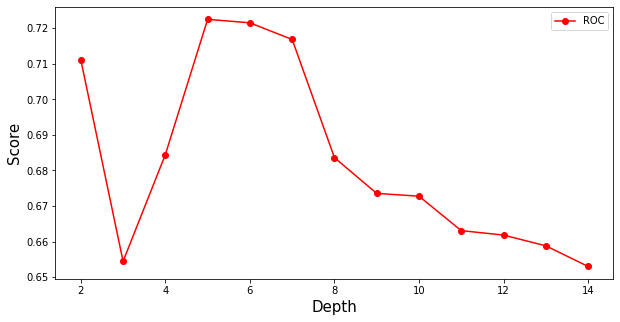

In [27]:
x_plot = range(2, 15)
y_plot = []

for depth in x_plot:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = validate_model(model, x_train, y_train)
    y_plot.append(np.mean(scores))

plt.figure(figsize=(10,5))
plt.plot(x_plot, y_plot, '-ro', label='ROC')
plt.xlabel('Depth', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()
plt.show()

<AxesSubplot:>

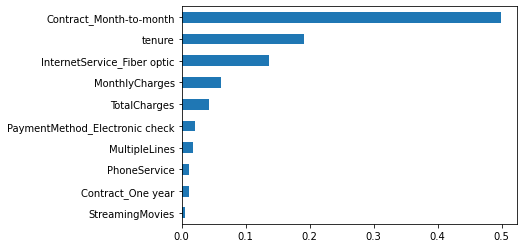

In [28]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(x_train, y_train)
importances = model.feature_importances_
weights = pd.Series(importances, index=x_train.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

#### Modelo 5: Floresta Aleatória

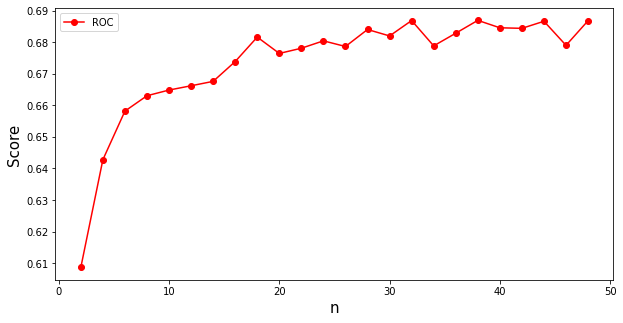

In [29]:
x_plot = range(2, 50, 2)
y_plot = []
for n in x_plot:
    model = RandomForestClassifier(n_estimators=n)
    scores = validate_model(model, x_train, y_train)
    y_plot.append(np.mean(scores))

plt.figure(figsize=(10,5))
plt.plot(x_plot, y_plot, '-ro', label='ROC')
plt.xlabel('n', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()
plt.show()

## Testando o modelo escolhido

Como a área da curva ROC foi maior utilizando o modelo Naive Bayes, o utilizaremos para fazer as predições do conjunto de teste final.

In [30]:
model = GaussianNB()
model.fit(x_train, y_train)

GaussianNB()

Podemos plotar a curva ROC para o modelo escolhido.

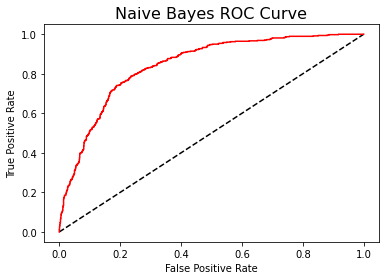

In [31]:
y_pred_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Gaussian Naive Bayes',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve', fontsize=16)
plt.show()

Por fim, calculamos o ROC score no conjunto de teste.

In [32]:
y_pred = model.predict(x_test)
roc_auc_score(y_test, y_pred)

0.7709826764678104

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1282
           1       0.53      0.81      0.64       479

    accuracy                           0.75      1761
   macro avg       0.72      0.77      0.73      1761
weighted avg       0.81      0.75      0.76      1761



Assim, podemos ver que o modelo Naive Bayes apresentou uma boa predição, com um score de aproximadamente 0.77. Analisando o relatório de classificação, pode-se ver que ele conseguiu prever os casos em que Churn=0 com uma precisão maior do que Churn=1.

### Conclusão

O modelo que apresentou a melhor métrica no conjunto de treino foi o GaussianNB, e este também obteve boa performance no conjunto de teste, com um score de 77%.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7a824f5-c5ed-4b9e-96e4-0df2979a8918' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>